In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# The Problem

It can often be difficult to identify cancer cells in patient imaging. The objective of this mini project is to create an image classification model using deep learning. We will be using a CNN or convolution neural network to train and classify the images that are in the dataset. This problem will be a binary classification of if the patient has Cancer or not. 

This notebook will follow the process of EDA, building and designing a model, and getting explorig results. The first pass will be an initial approach into how well the model does. From there we will build toward hyperparameters to create a better and better model

## Data

The provided data is split into two folders. Train and Test. Inside each of these is numerous images with the .tif extension. Looking at one of the images it has the demensions 96 X 96 pixels. Bit depth of 24. We also have a the labels of the imaging for the train data in train_labels.csv

## Pre processing (EDA)
### First pass
I initially converted all .tif files to png's since I believed these would be easier to work with. In the end I was able to use the .tif files directly. Some of the inital approaches I took to preprocessing were as follows.
- using (64,64) standard sizing of all images
- inial train_datgen doing rescale 1./255 and validation split of 0.2
### Second pass 
I will go ahead and add the following
```
train_datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalize pixel values to [0, 1]
    rotation_range=20,         # Random rotation
    width_shift_range=0.2,     # Horizontal shift
    height_shift_range=0.2,    # Vertical shift
    shear_range=0.15,          # Shear transformation
    zoom_range=0.2,            # Zoom in/out
    horizontal_flip=True,      # Random horizontal flip
    fill_mode='nearest',       # Fill in empty pixels after transform
    validation_split=0.2       # Split data into training/validation
)
```

In [ ]:
from PIL import Image
import os

input_dir = "histopathologic-cancer-detection/train"
output_dir = "histopathologic-cancer-detection/train_png"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        img = Image.open(os.path.join(input_dir, filename))
        new_filename = filename.rsplit('.', 1)[0] + ".png"  # or ".jpg"
        img.save(os.path.join(output_dir, new_filename))

input_dir = "histopathologic-cancer-detection/test"
output_dir = "histopathologic-cancer-detection/test_png"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        img = Image.open(os.path.join(input_dir, filename))
        new_filename = filename.rsplit('.', 1)[0] + ".png"  # or ".jpg"
        img.save(os.path.join(output_dir, new_filename))

In [6]:
train_df = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")

In [7]:
train_df['filename'] = train_df['id'].astype(str) + '.tif'
train_df['label'] = train_df['label'].astype(str)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalize pixel values to [0, 1]
    rotation_range=20,         # Random rotation
    width_shift_range=0.2,     # Horizontal shift
    height_shift_range=0.2,    # Vertical shift
    shear_range=0.15,          # Shear transformation
    zoom_range=0.2,            # Zoom in/out
    horizontal_flip=True,      # Random horizontal flip
    fill_mode='nearest',       # Fill in empty pixels after transform
    validation_split=0.2       # Split data into training/validation
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    directory='./histopathologic-cancer-detection/train/',
    color_mode='rgb',       # or 'grayscale' if needed
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    directory='./histopathologic-cancer-detection/train/',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='validation',
    seed=42
)

test_dir = './histopathologic-cancer-detection/test/'
test_filenames = os.listdir(test_dir)

# Optional: filter to .tif only
test_filenames = [f for f in test_filenames if f.endswith('.tif')]

test_df = pd.DataFrame({
    'filename': test_filenames
})

test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Model architecture
### First Pass

To start we will use some basic architecture and measure a baseline accuracy. Since the model is rgb we will be using an input size of (height, width, 3)
For the number of layers I will use two Conv layers using relu and 2 MaxPooling using (2,2) size. I think that since the images are a bit smaller 96 X 96 its better to use 2,2 instead of 3,3 for our pooling. For the output activation layers we will be using sigmoid since it is a binary classification problem.

## Hyper parameter tuning
### Second Pass:
- adding in Early stopping with a patience of 3
- add in a adjustable learning rate modifier that is using Adam with 0.001 learning rate and bases off of val_loss

### Thirds Pass:
- Convert the model to take an input of 96, 96 to more closely match the images themselves
- Add batch normalization to help with training speeds and accuracy
- Add Droputs after layers to help with overfitting
- Increased the Adam starting learning rate from 0.001 to 0.0005 since its training too slowly

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # or 1 with 'sigmoid' if binary
])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',   # because it's binary classification
    metrics=['accuracy']
)
   
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

learning_rate = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=5,
    batch_size=32,
    callbacks=[early_stop, learning_rate]
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 495s 90ms/step - accuracy: 0.8588 - loss: 0.3273 - val_accuracy: 0.7129 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 706s 128ms/step - accuracy: 0.8639 - loss: 0.3181 - val_accuracy: 0.8200 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 806s 147ms/step - accuracy: 0.8696 - loss: 0.3075 - val_accuracy: 0.7686 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 413s 75ms/step - accuracy: 0.8717 - loss: 0.3008 - val_accuracy: 0.8254 - val_loss: 0.4022 - learning_rate: 0.0010
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 425s 77ms/step - accuracy: 0.8707 - loss: 0.3012 - val_accuracy: 0.7978 - val_loss: 0.5118 - learning_rate: 0.0010


In [20]:
preds = model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step


In [21]:
predicted_classes = (preds > 0.5).astype(int).flatten()
print(predicted_classes)

pd.DataFrame({
    'id': test_df['filename'].str.replace('.tif', '',regex=False),
    'label':predicted_classes
}).to_csv('submission.csv', index=False, header=True)

[1 1 0 ... 0 0 0]


## Results and Analysis

### First Pass:
The initial test run resulted in recieving a private score of 0.78 and a public score of 0.84. This places me around #1025. There are a lot of good scored in this competition. 

### Second Pass:
After adding in the early stopping and the learning rate modifier I actually recieved a much lower score, around 0.7, I increased the number of epochs to 20 but the early stopping only got it to 4. I think this could be a sign of training too fast. Since the training loss decreased vut the validation loss increased we are likely overfitting. 

### Third Pass:

The third pass took about 6 hours to do 5 epochs. I think that the batch size is too small. Also, the public score had dropped all the way to 0.632. Clearly the addition of early stopping as well as a smaller learning rate was worse for the results. Also when looking at the charts below you can see that the validation loss went up near the end of the training. This is likely since the early stopping patience was too large. I would like to continue to see if I can make more improvements however, the rate of training is so slow it would be hard to do a hyperparameter grid search on this data set.

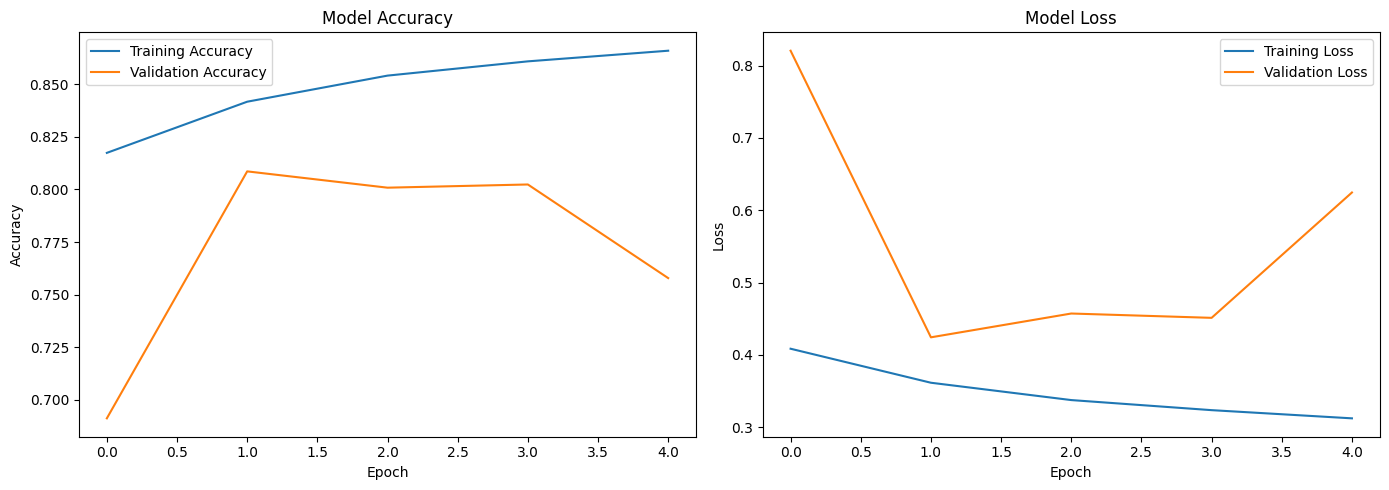

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusion

overall the biggest issue that I had with this project was the time to train. I would have liked to do some hyper parameter training but each run took around 2-6 hours depending on the configurations. The first run that I configured had the best score of 0.84 on the kaggle leaderboards. After that the scores went down and up depending on how I setup the configurations. I thought that early stopping and adjusting the learning rate would have helped to improve the scores, but I was wrong. Even on the last run that can be seen in the charts above the the validation accuracy dropped off at the end and the validation loss went up at the end. This is an indication that the model was trained for too long. Even so the best accuracy that was seen was around 0.82 which is not that good all in all. 